# Estimating hotspot(s) emission using NeRF. 

Notes:
Inner most stable circular orbit (ISCO), for spin=0 this is at 3M \
Overleaf notes: https://www.overleaf.com/project/60ff0ece5aa4f90d07f2a417

In [1]:
import sys
sys.path.append('../bhnerf')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import xarray as xr

import functools
import flax

from flax import optim
from flax.training import train_state
import optax

import jax
from jax import lax
from jax import random
import jax.experimental.optimizers


import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('animation', html='jshtml')

import utils, emission_utils, visualization, network_utils

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2ii5_emr because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# No shearing (hotspot shape persists)

In [32]:
# Generate hotspot emission
nt, ny, nx = 64, 64, 64
nt_test = 64
nspots = 4
r_isco = 3.0 

theta = np.random.rand(nspots) * 2. * np.pi 
orbit_radius = np.linspace(3.1, 3.95, nspots) 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_2d(ny, nx, theta, orbit_radius, std, r_isco)

velocity_field = 2.0
emission = emission_utils.generate_orbit_2d(initial_frame, nt, velocity_field)
emission_test = emission_utils.generate_orbit_2d(initial_frame, nt_test, velocity_field)

In [33]:
# Generate radiance measurements 
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo200_npix200.nc')
sensor = sensor.isel(geo=range(0, sensor.geo.size, 2), 
                     pix=range(0, sensor.pix.size, 2))
# sensor = sensor.where(sensor.r < 5)
    
measurements = emission_utils.integrate_rays(emission, sensor)
measurements_test = emission_utils.integrate_rays(emission_test, sensor)

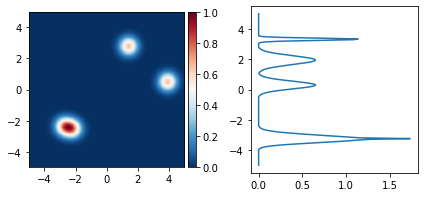

In [23]:
fig, axes = plt.subplots(1,2)
visualization.animate_synced(emission, measurements, axes, add_ticks=True)

In [29]:
from flax import linen as nn
from typing import Any, Callable
import jax.numpy as jnp

def get_input_coords(sensor, nt, ngeo=None, npix=None):
    
    ngeo = ngeo if ngeo else sensor.geo.size
    npix = npix if npix else sensor.pix.size
    
    if 't' in sensor:
        sensor = sensor.drop('t')
        
    interpolated_sensor = sensor.expand_dims(t=nt).interp(
        geo=np.linspace(0, sensor.geo.size-1, ngeo),
        pix=np.linspace(0, sensor.pix.size-1, npix)
    )
    t = np.broadcast_to(np.linspace(0, 1, nt)[:, None, None], [nt, npix, ngeo])
    coordinates = {
        't': t.reshape(nt*npix, ngeo),
        'x': interpolated_sensor.x.data.reshape(nt*npix, ngeo),
        'y': interpolated_sensor.y.data.reshape(nt*npix, ngeo),
        'z': interpolated_sensor.z.data.reshape(nt*npix, ngeo),
        'd': interpolated_sensor.deltas.data.reshape(nt*npix, ngeo)
    }
    return coordinates

class MLP(nn.Module):
    """A simple MLP."""

    net_depth: int = 4
    net_width: int = 256
    activation: Callable[..., Any] = nn.elu
    out_channel: int = 1
    do_skip: bool = True

    @nn.compact
    def __call__(self, x):
        """Multi-layer perception for nerf.

        Args:
          x: jnp.ndarray(float32), [batch_size * n_samples, feature], points.
          net_depth: int, the depth of the first part of MLP.
          net_width: int, the width of the first part of MLP.
          activation: function, the activation function used in the MLP.
          out_channel: int, the number of alpha_channels.
          do_skip: boolean, whether or not to use a skip connection

        Returns:
          out: jnp.ndarray(float32), [batch_size * n_samples, out_channel].
        """
        dense_layer = functools.partial(
            nn.Dense, kernel_init=jax.nn.initializers.he_uniform())

        if self.do_skip:
            skip_layer = self.net_depth // 2

        inputs = x
        for i in range(self.net_depth):
            x = dense_layer(self.net_width)(x)
            x = self.activation(x)
            if self.do_skip:
                if i % skip_layer == 0 and i > 0:
                    x = jnp.concatenate([x, inputs], axis=-1)
        out = dense_layer(self.out_channel)(x)

        return out
    
class PREDICT_EMISSION(nn.Module):
    """Full function to predict emission at a time step."""

    @nn.compact
    def __call__(self, x, y, t):

        emission_MLP = MLP()

        def predict_emission(x, y, t):
    
            net_input = emission_utils.velocity_warp_2d(x, y, t, velocity_field, jax=True)
            valid_inputs_mask = jnp.isfinite(net_input)
            net_input = jnp.where(valid_inputs_mask, net_input, jnp.zeros_like(net_input))
            net_output = emission_MLP(posenc(net_input, posenc_deg))
            emission = nn.sigmoid(net_output[..., 0])
            #emission = jnp.where(valid_inputs_mask[..., 0], emission, jnp.zeros_like(emission))

            # Ground truth emission
            # radius_gt = 3.5
            # theta_gt = np.pi / 2.
            # center = [radius_gt * jnp.cos(theta_gt), radius_gt * jnp.sin(theta_gt)]
            # std = 0.4
            # emission = jnp.exp(-0.5*( (y_rot - center[1])**2 + (x_rot - center[0])**2 ) / std**2)
            # emission = jnp.where(jnp.isfinite(emission), emission, jnp.zeros_like(emission))

            return emission

        emission = predict_emission(x, y, t)

        return emission
    
def safe_sin(x):
    """jnp.sin() on a TPU will NaN out for moderately large values."""
    return jnp.sin(x % (100 * jnp.pi))

def posenc(x, deg):
    """Concatenate `x` with a positional encoding of `x` with degree `deg`.

    Instead of computing [sin(x), cos(x)], we use the trig identity
    cos(x) = sin(x + pi/2) and do one vectorized call to sin([x, x+pi/2]).

    Args:
    x: jnp.ndarray, variables to be encoded. Note that x should be in [-pi, pi].
    deg: int, the degree of the encoding.

    Returns:
    encoded: jnp.ndarray, encoded variables.
    """
    if deg == 0:
        return x
    scales = jnp.array([2**i for i in range(deg)])
    xb = jnp.reshape((x[..., None, :] * scales[:, None]),
                     list(x.shape[:-1]) + [-1])
    four_feat = safe_sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1))
    return jnp.concatenate([x] + [four_feat], axis=-1)

def shard(xs):
    """Split data into shards for multiple devices along the first dimension."""
    return jax.tree_map(lambda x: x.reshape((jax.local_device_count(), -1) + x.shape[1:]), xs)

In [30]:
train_coords = get_input_coords(sensor, nt=emission.t.size)
t, x, y, z, d = train_coords.values()
train_radiance = measurements.data.ravel() 

test_coords = get_input_coords(sensor, nt=emission_test.t.size)
test_radiance = measurements_test.data.ravel() 
t_test, x_test, y_test, z_test, d_test = test_coords.values()

iteration: 1


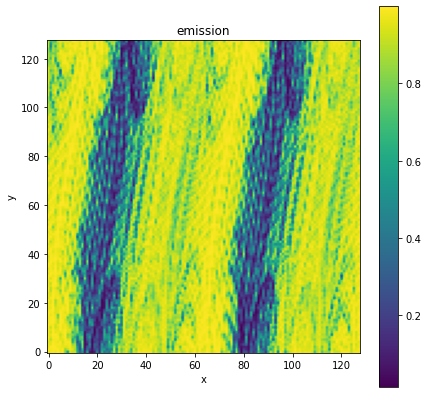

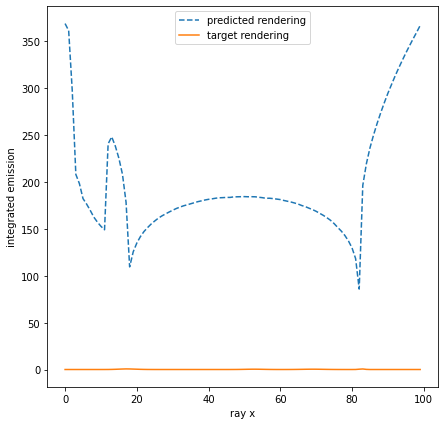

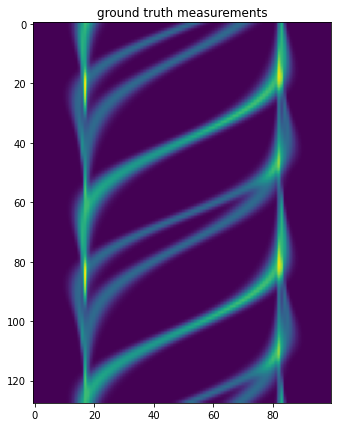

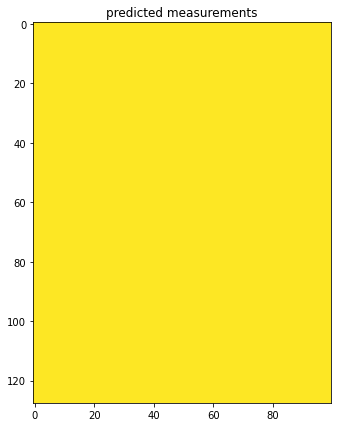

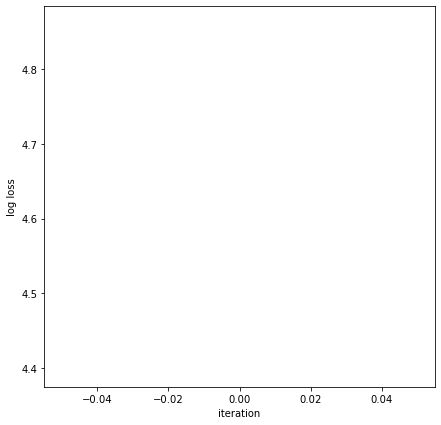

2021-08-23 17:49:36.869425: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 13.68GiB (rounded to 14689281024)requested by op 
2021-08-23 17:49:36.870210: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:473] *___________________________________________________________________________________________________
2021-08-23 17:49:36.870349: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2085] Execution of replica 0 failed: Resource exhausted: Out of memory while trying to allocate 14689280992 bytes.


RuntimeError: Resource exhausted: Out of memory while trying to allocate 14689280992 bytes.

In [31]:
# Emission visualization inputs
t_res_vis, y_res_vis, x_res_vis = 64, 64, 64
y_vis, x_vis, t_vis = np.meshgrid(np.linspace(emission.y[0], emission.y[-1], y_res_vis),
                                  np.linspace(emission.x[0], emission.x[-1], x_res_vis),
                                  np.linspace(emission.t[0], emission.t[-1], t_res_vis),
                                  indexing='ij')
d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
target_vis = np.ones([y_res_vis, x_res_vis]) # meaningless placeholder for emission visualization

# Training parameters
lr_init = 1e-4
lr_final = 1e-6
num_iters = 10000

posenc_deg = 6

# Model setup and initialization
rng = jax.random.PRNGKey(1)
predictor = PREDICT_EMISSION()
params = predictor.init(rng, x[:1, ...], y[:1, ...], t[:1, ...])['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(lr_init, lr_final, 1, num_iters))
state = train_state.TrainState.create(apply_fn=PREDICT_EMISSION.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

def lossfn(params, x, y, d, t, target, key):
    emission = predictor.apply({'params': params}, x, y, t)
    rendering = jnp.sum(emission * d, axis=-1)
    loss = jnp.mean((rendering - target)**2)
    return loss, [emission, rendering]

@jax.jit
def train_step(i, x, y, d, t, target, state, key):
    key, new_key = random.split(key)
    vals, grads = jax.value_and_grad(lossfn, argnums=(0), has_aux=True)(state.params, x, y, d, t, target, new_key)
    grads = jax.lax.pmean(grads, axis_name='batch')
    state = state.apply_gradients(grads=grads)
    loss, [emission, rendering] = vals
    return loss, state, emission, rendering, new_key

@jax.jit
def eval_step(i, x, y, d, t, target, state, key):
    key, new_key = random.split(key)
    vals, grads = jax.value_and_grad(lossfn, argnums=(0), has_aux=True)(state.params, x, y, d, t, target, new_key)
    loss, [emission, rendering] = vals
    return loss, state, emission, rendering, new_key

train_pstep = jax.pmap(train_step, axis_name='batch', in_axes=(None, 0, 0, 0, 0, 0, 0, 0))
eval_pstep = jax.pmap(eval_step, axis_name='batch', in_axes=(None, 0, 0, 0, 0, 0, 0, 0))

rand_key = jax.random.split(rng, jax.local_device_count())
state = flax.jax_utils.replicate(state)

emission_list = []
rendering_list = []
loss_list = []
for i in range(1, num_iters+1):

    if i==1 or i % 100 == 0:
        # Testing
        loss_test, _, emission_pred_test, rendering_test, _ = eval_pstep(i, shard(x_test), shard(y_test), shard(d_test), shard(t_test), shard(test_radiance), state, rand_key)
        rendering_test = np.reshape(rendering_test, [emission_test.t.size, sensor.pix.size])
        rendering_list.append(rendering_test)
        loss_list.append(np.mean(loss_test))

    if i==1 or i % 100 == 0:
        # Visualization
        _, _, emission_vis, _, _ = eval_pstep(i, shard(x_vis), shard(y_vis), shard(d_vis), shard(t_vis), shard(target_vis), state, rand_key)
        emission_vis = np.reshape(emission_vis, [t_res_vis, y_res_vis, x_res_vis])
        emission_list.append(emission_vis)

        print('iteration:', i)

        plt.figure(figsize=(7,7))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.imshow(emission_vis[0], origin='lower')
        plt.title('emission')
        plt.colorbar()
        plt.show()

        plt.figure(figsize=(7,7))
        plt.xlabel('ray x')
        plt.ylabel('integrated emission')
        plt.plot(rendering_test[0], label='predicted rendering', linestyle='--')
        plt.plot(np.reshape(test_radiance, [emission_test.t.size, sensor.pix.size])[0], label='target rendering')
        plt.legend()
        plt.show()

        plt.figure(figsize=(7,7))
        plt.title('ground truth measurements')
        plt.imshow(measurements_test.data, 
                   vmin=np.amin(measurements_test.data), 
                   vmax=np.amax(measurements_test.data))
        plt.show()

        plt.figure(figsize=(7,7))
        plt.title('predicted measurements')
        plt.imshow(rendering_test,
                   vmin=np.amin(measurements_test.data), 
                   vmax=np.amax(measurements_test.data))
        plt.show()

        plt.figure(figsize=(7,7))
        plt.xlabel('iteration')
        plt.ylabel('log loss')
        plt.plot(np.log10(loss_list))
        plt.show()


        # Training
        _, state, _, _, rand_key = train_pstep(i, shard(x), shard(y), shard(d), shard(t), shard(train_radiance), state, rand_key)

# DEBUG

In [86]:
def curved_sensor(pixel_res, ray_res, bh_mask, fov=1.0, num_refinements=10):
  y0 = -fov/2
  sensor = []
  for u in range(pixel_res):

      b = fov * (u/pixel_res - 0.5)
      b_sign = np.sign(b)
      b = np.abs(b)

      if np.allclose(b, 0):
          y = np.linspace(-fov/2, -rg, ray_res)
          x = np.full_like(y, fill_value=b)
      else:
          psi0 = np.arcsin(b/np.sqrt(b**2 + y0**2))
          psi1 = 2*np.pi - psi0
          psi = np.linspace(psi0, psi1, ray_res)

          # Eq.(3) of https://arxiv.org/pdf/astro-ph/0201117.pdf
          r = np.sqrt(rg**2*(1-np.cos(psi))**2 / (4*(1+np.cos(psi))**2) + b**2 / np.sin(psi)**2) - \
              (rg*(1-np.cos(psi)) / (2*(1+np.cos(psi))))

          # Refinement of resolution for rays that intersect rg (Schwarzschild radius)
          x = b_sign * r * np.sin(psi)
          y = -r * np.cos(psi)
          for i in range(num_refinements):
              bh_check = bh_mask.sel(x=xr.DataArray(x), y=xr.DataArray(y), method='nearest')
              if bh_check.any():
                  psi1 = psi[bh_check.astype(float).argmax()] 
                  psi = np.linspace(psi0, psi1, ray_res)

                  # Recompute Eq.(3) with samples up to rg
                  r = np.sqrt(rg**2*(1-np.cos(psi))**2 / (4*(1+np.cos(psi))**2) + b**2 / np.sin(psi)**2) - \
                      (rg*(1-np.cos(psi)) / (2*(1+np.cos(psi))))

                  x = b_sign * r * np.sin(psi)
                  y = -r * np.cos(psi)
              else:
                  break

      x = xr.DataArray(x, dims=['v'], coords={'v': range(ray_res)}).expand_dims(u=[u])
      y = xr.DataArray(y, dims=['v'], coords={'v': range(ray_res)}).expand_dims(u=[u])
      piecwise_dist = xr.concat((xr.zeros_like(x.isel(v=0)), np.sqrt(x.diff('v')**2 + y.diff('v')**2)), dim='v')
      ray = xr.Dataset(coords={'x': x, 'y': y}).assign_coords({'deltas': (['u', 'v'], piecwise_dist)})

      sensor.append(ray)

  sensor = xr.concat(sensor, dim='u')
  return sensor

num_rays = 64
num_samples = 64
rg = 2.0
bh_mask = emission.x**2 + emission.y**2 < rg**2
sensor = curved_sensor(pixel_res=num_rays, ray_res=num_samples, bh_mask=bh_mask, fov=10.0)

sensor = sensor.rename(u='pix', v='geo')
measurements = emission_utils.integrate_rays(emission, sensor)
measurements_test = emission_utils.integrate_rays(emission_test, sensor)

# Shearing effects 

In [ ]:
# Hotspot params (multiple)
nt, ny, nx = 100, 100, 100
nspots = 4
r_isco = 3.0 

theta = np.random.rand(nspots) * 2. * np.pi 
orbit_radius = np.linspace(3.5, 4., nspots) 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission.generate_hotspots(ny, nx, theta, orbit_radius, std, r_isco)

orbit_period = 3.5**(-3./2.) 
velocity_field = (1.0 / orbit_period) * initial_frame.r**(-3/2)
hotspot_orbit = emission.generate_orbit(initial_frame, nt, velocity_field=velocity_field)